In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Parameters
time_steps = 10
channels = 1  # Grayscale images

# Load and preprocess the training data
training_data_path = '/Users/sb3323/Desktop/Group Project/acds3-wildfire-logan/Ferguson_fire_train.npy'
training_data = np.load(training_data_path)
test_data = np.load('/Users/sb3323/Desktop/Group Project/acds3-wildfire-logan/Ferguson_fire_test.npy')
obs_data = np.load('/Users/sb3323/Desktop/Group Project/acds3-wildfire-logan/Ferguson_fire_obs.npy')

# Expected shape: (num_samples, 256, 256)
print('Original training data shape:', training_data.shape)

# Reshape data to include channel dimension
training_data = np.expand_dims(training_data, axis=-1)

# Expected shape after adding channel dimension: (num_samples, 256, 256, 1)
print('Training data with channel dimension:', training_data.shape)
print('Test data shape:', test_data.shape)
print('Observation data shape:', obs_data.shape)


Original training data shape: (12500, 256, 256)
Training data with channel dimension: (12500, 256, 256, 1)
Test data shape: (5000, 256, 256)
Observation data shape: (5, 256, 256)


In [2]:
# split data into train and validation
train_data = []
validation_data = []

for i in range(0, len(training_data), 500):
    train_data.extend(training_data[i:i+400])
    validation_data.extend(training_data[i+400:i+500])
    
train_data = np.array(train_data)
validation_data = np.array(validation_data)

print('Train data shape:', train_data.shape)
print('Validation data shape:', validation_data.shape)
print('Test data shape:', test_data.shape)


Train data shape: (10000, 256, 256, 1)
Validation data shape: (2500, 256, 256, 1)
Test data shape: (5000, 256, 256)


In [3]:
def data_reformat(data):
    time_step = 100
    height, width = data.shape[1], data.shape[2]

    num_sequences = data.shape[0] // time_step
    reshaped_data = data[:num_sequences * time_step].reshape((num_sequences, time_step, height, width,))

    # only take 0,10,20,30,40,50,60,70,80,90 time steps from each sequence
    reshaped_data = reshaped_data[:, ::10, :, :]

    return reshaped_data

train_data = data_reformat(train_data)
validation_data = data_reformat(validation_data)
test_data = data_reformat(test_data)

print('Train data shape:', train_data.shape)
print('Validation data shape:', validation_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (100, 10, 256, 256)
Validation data shape: (25, 10, 256, 256)
Test data shape: (50, 10, 256, 256)


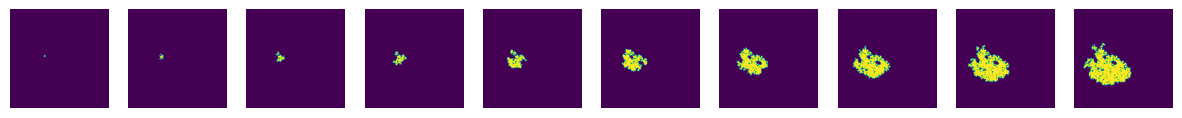

In [4]:
fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    ax[i].imshow(train_data[40, i,:,:])
    ax[i].axis('off')

Train t data shape: (100, 9, 256, 256)
Train t+1 data shape: (100, 9, 256, 256)


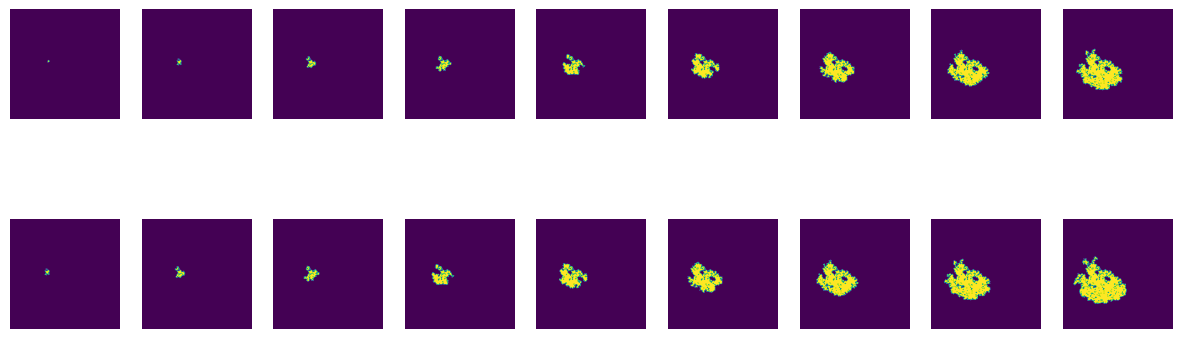

In [5]:
# create t and t+1 data group
def create_data_group(data):
    t_data = data[:, :-1]
    t1_data = data[:, 1:]
    
    return t_data, t1_data

train_t_data, train_t1_data = create_data_group(train_data)
validation_t_data, validation_t1_data = create_data_group(validation_data)

print('Train t data shape:', train_t_data.shape)
print('Train t+1 data shape:', train_t1_data.shape)

fig, ax = plt.subplots(2, 9, figsize=(15, 5))
for i in range(9):
    ax[0, i].imshow(train_t_data[40, i,:,:])
    ax[0, i].axis('off')
    ax[1, i].imshow(train_t1_data[40, i,:,:])
    ax[1, i].axis('off')

In [6]:
import numpy as np

# Create t and t+1 data groups
def create_data_group(data):
    t_data = data[:, :-1]
    t1_data = data[:, -1]
    return t_data, t1_data

# Create t and t+1 data groups for training and validation data
train_t_data, train_t1_data = create_data_group(train_data)
validation_t_data, validation_t1_data = create_data_group(validation_data)

# Add channel dimension to each dataset
train_t_data = np.expand_dims(train_t_data, axis=-1)
train_t1_data = np.expand_dims(train_t1_data, axis=-1)
validation_t_data = np.expand_dims(validation_t_data, axis=-1)
validation_t1_data = np.expand_dims(validation_t1_data, axis=-1)

# Expected shapes:
# train_t_data: (num_samples, time_steps-1, 256, 256, 1)
# train_t1_data: (num_samples, 256, 256, 1)
print('Train t data shape:', train_t_data.shape)
print('Train t+1 data shape:', train_t1_data.shape)
print('Validation t data shape:', validation_t_data.shape)
print('Validation t+1 data shape:', validation_t1_data.shape)


Train t data shape: (100, 9, 256, 256, 1)
Train t+1 data shape: (100, 256, 256, 1)
Validation t data shape: (25, 9, 256, 256, 1)
Validation t+1 data shape: (25, 256, 256, 1)


In [7]:
def build_temporal_generator(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    
    return models.Model(inputs, x, name='temporal_generator')

In [8]:
from tensorflow.keras import layers, models

def build_discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, x, name='discriminator')


In [9]:
from livelossplot import PlotLossesKerasTF

new_width, new_height = 256, 256

def build_gan(generator, discriminator):
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(time_steps - 1, new_width, new_height, channels))
    generated_frame = generator(gan_input)
    gan_output = discriminator(generated_frame)
    gan = models.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

# Example shapes, adjust to your data
input_shape = (time_steps - 1, new_width, new_height, channels)

# Build and compile the models
generator = build_temporal_generator(input_shape)
discriminator = build_discriminator((new_width, new_height, channels))
gan = build_gan(generator, discriminator)

# Training parameters
batch_size = 32
epochs = 25


# Initialize the live plot
liveplot = PlotLossesKerasTF()

# Training loop
for epoch in range(epochs):
    # Select a random batch of sequences
    idx = np.random.randint(0, train_t_data.shape[0], batch_size)
    real_seqs = train_t_data[idx]
    real_frames = train_t1_data[idx]

    # Ensure the shapes match the expected input shape
    assert real_seqs.shape == (batch_size, time_steps - 1, new_width, new_height, channels)
    assert real_frames.shape == (batch_size, new_width, new_height, channels)
    
    # Generate a batch of new frames
    generated_frames = generator.predict(real_seqs)

    # Create labels for real and fake frames
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_frames, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_frames, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    g_loss = gan.train_on_batch(real_seqs, real_labels)

    # Update live plot
    # logs = {'d_loss': d_loss[0], 'd_acc': d_loss[1], 'g_loss': float(g_loss)}
    # liveplot.on_epoch_end(epoch, logs)
    logs = {'d_loss': float(d_loss[0]), 'd_acc': float(d_loss[1]), 'g_loss': float(g_loss[0])}
    liveplot.on_epoch_end(epoch, logs)
    
    # Print the progress
    if epoch % 5 == 0:
        print(f"Epoch {epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")

# Complete live plot
liveplot.on_train_end()


/Users/sb3323/anaconda3/envs/dsml4p/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate MSE Loss and Generate Next Image
# Select a random batch of sequences from the validation set for testing
idx = np.random.randint(0, validation_t_data.shape[0], batch_size)
test_seqs = validation_t_data[idx]
true_next_frames = validation_t1_data[idx]

# Generate the next frames using the trained generator
predicted_next_frames = generator.predict(test_seqs)

# Calculate MSE loss
mse_loss = np.mean((true_next_frames - predicted_next_frames) ** 2)
print(f"MSE Loss: {mse_loss}")

# Invert the colors of the predicted next frame
predicted_next_frames_inverted = 1 - predicted_next_frames

# Plot the true and predicted next frame for the first sequence in the batch
plt.figure(figsize=(10, 2))

# True next frame
plt.subplot(1, 2, 1)
plt.title("True Next Frame")
plt.imshow(true_next_frames[0, :, :, 0])
plt.axis('off')

# Predicted next frame (with inverted colors)
plt.subplot(1, 2, 2)
plt.title("Predicted Next Frame (Inverted Colors)")
plt.imshow(predicted_next_frames_inverted[0, :, :, 0])
plt.axis('off')

plt.show()
